In [139]:
from scipy.stats import uniform, expon, poisson
import numpy as np
from TemporalNetwork import ContTempNetwork
import matplotlib.pyplot as plt

In [183]:
inter_tau = 5
activ_tau = 0.25
n_per_group = 3
n_groups = 27
t_start = 0
t_end = 300

In [184]:
number_of_events = poisson.rvs(size = 1, mu = (t_end - t_start) / activ_tau)[0]

In [185]:
number_of_events

1172

In [186]:
starting_times = np.sort(uniform.rvs(size=number_of_events, loc=t_start, scale=t_end - t_start))

In [187]:
ending_times = expon.rvs(size=number_of_events, scale= inter_tau)
ending_times = ending_times + starting_times

In [188]:
source_nodes = np.random.choice( n_groups * n_per_group, number_of_events, replace=True)

In [189]:
source_nodes

array([40, 46, 35, ..., 38, 51, 58])

In [190]:
def make_step_block_probs2(deltat1, num_cores=27, n_per_group = 3, basis_num_communities = 3, powers_num_communities = [3, 2, 1], list_p_within_community = [49/50] * len([27, 9, 3])):
    """
    Returns a function that generates the block probability matrix as a function of time.

    Parameters:
    - deltat1 (int): Length of each temporal step.
    - num_cores (int): Total number of cores in the network.
    - basis_num_communities (int): The base number of communities for symmetry.
    - powers_num_communities (list of int): Powers of the base defining the number of communities in each stage.
    - list_p_within_community (list of float): List of within-community interaction probabilities for each stage.

    """
    
    list_num_communities=list(np.power(basis_num_communities, powers_num_communities))
    
    def calculate_pout(p_within, community_size, total_size):
        k = (1 / p_within - community_size) / (total_size - community_size)
        return k * p_within

    def generate_block_matrix(num_communities, p_within_base):
        # Determine community sizes
        community_size = num_cores // num_communities
        
        p_within = p_within_base / community_size
        p_within_outgroup = p_within_base / (community_size * n_per_group -1) * n_per_group # Adjust within probability by the number of cores per community
        p_within_ingroup = p_within_base / (community_size * n_per_group -1) * (n_per_group-1) # # Correction for same group 
        
        pout = calculate_pout(p_within, community_size, num_cores)

        # Create block matrix
        block_matrix = np.zeros((num_cores, num_cores))
        for i in range(num_communities):
            start = i * community_size
            end = start + community_size
            block_matrix[start:end, start:end] = p_within_outgroup / n_per_group

        np.fill_diagonal(block_matrix, p_within_ingroup / (n_per_group-1), wrap=False) # Correction for same group 
        block_matrix[block_matrix == 0] = pout / n_per_group
        
        return block_matrix

    # Precompute the matrices for different stages
    stage_matrices = []
    for num_communities, p_within_community in zip(list_num_communities, list_p_within_community):
        stage_matrices.append(generate_block_matrix(num_communities, p_within_community))

    def block_mod_func(t):
        total_stages = len(stage_matrices)
        stage_duration = deltat1

        for stage_index in range(total_stages):
            if t >= stage_index * stage_duration and t < (stage_index + 1) * stage_duration:
                return stage_matrices[stage_index]

        print("Warning: t is out of bounds. Returning identity matrix.")
        return np.eye(num_cores)

    return block_mod_func

In [191]:
# block_mod_func = make_step_block_probs2(deltat1 = 100, num_cores=n_groups, n_per_group=3, basis_num_communities=3, powers_num_communities=[3,2,1], list_p_within_community=[49/50] * len([27,9,3]))
# a = block_mod_func(100)
# a = np.repeat(a, n_per_group, axis= 0)
# a = np.repeat(a, n_per_group, axis= 1)
# np.fill_diagonal(a, 0, wrap=False) # no self-events

In [192]:
def make_step_block_probs(deltat1, num_cores=27, n_per_group = 3, basis_num_communities = 3, powers_num_communities = [3, 2, 1], list_p_within_community = [49/50] * len([27, 9, 3])):
    """
    Returns a function that generates the block probability matrix as a function of time.

    Parameters:
    - deltat1 (int): Length of each temporal step.
    - num_cores (int): Total number of cores in the network.
    - basis_num_communities (int): The base number of communities for symmetry.
    - powers_num_communities (list of int): Powers of the base defining the number of communities in each stage.
    - list_p_within_community (list of float): List of within-community interaction probabilities for each stage.

    """
    
    list_num_communities=list(np.power(basis_num_communities, powers_num_communities))
    
    def calculate_pout(p_within, community_size, total_size):
        k = (1 / p_within - community_size) / (total_size - community_size)
        return k * p_within

    def generate_block_matrix(num_communities, p_within_base):
        # Determine community sizes
        community_size = num_cores // num_communities
        
        p_within = p_within_base / community_size
        p_within_outgroup = p_within_base / (community_size * n_per_group -1)  # Adjust to avoid self_events
        
        pout = calculate_pout(p_within, community_size, num_cores) / n_per_group

        # Create block matrix
        block_matrix = np.zeros((num_cores*n_per_group, num_cores*n_per_group))
        for i in range(num_communities):
            start = i * community_size*n_per_group
            end = start + community_size*n_per_group
            block_matrix[start:end, start:end] = p_within_outgroup 
 
        block_matrix[block_matrix == 0] = pout
        np.fill_diagonal(block_matrix, 0 , wrap=False) # Correction for self_events
        
        return block_matrix

    # Precompute the matrices for different stages
    stage_matrices = []
    for num_communities, p_within_community in zip(list_num_communities, list_p_within_community):
        stage_matrices.append(generate_block_matrix(num_communities, p_within_community))

    def block_mod_func(t):
        total_stages = len(stage_matrices)
        stage_duration = deltat1

        for stage_index in range(total_stages):
            if t >= stage_index * stage_duration and t < (stage_index + 1) * stage_duration:
                return stage_matrices[stage_index]

        print("Warning: t is out of bounds. Returning identity matrix.")
        return np.eye(num_cores)

    return block_mod_func

In [193]:
block_mod_func = make_step_block_probs(deltat1 = 100, num_cores=n_groups, n_per_group=3, basis_num_communities=3, powers_num_communities=[3,2,1], list_p_within_community=[49/50] * len([27,9,3]))

In [203]:
target_nodes = []
for i, source in enumerate(source_nodes):
    target_nodes.append(np.random.choice(n_groups * n_per_group, 1, p=block_mod_func(starting_times[i])[source])[0])

In [204]:
target_nodes

[39,
 47,
 34,
 15,
 44,
 43,
 50,
 28,
 79,
 67,
 56,
 61,
 71,
 33,
 54,
 34,
 67,
 78,
 12,
 39,
 18,
 25,
 23,
 25,
 51,
 70,
 22,
 47,
 24,
 74,
 7,
 37,
 65,
 4,
 9,
 68,
 29,
 40,
 60,
 63,
 19,
 77,
 18,
 33,
 47,
 22,
 32,
 39,
 54,
 31,
 31,
 18,
 78,
 30,
 36,
 28,
 36,
 70,
 77,
 80,
 29,
 48,
 41,
 17,
 62,
 71,
 71,
 36,
 12,
 54,
 17,
 52,
 70,
 53,
 7,
 50,
 54,
 35,
 0,
 1,
 43,
 9,
 46,
 38,
 20,
 76,
 49,
 38,
 19,
 57,
 26,
 58,
 66,
 15,
 44,
 18,
 77,
 40,
 61,
 52,
 63,
 64,
 60,
 74,
 9,
 34,
 63,
 50,
 8,
 18,
 57,
 61,
 32,
 45,
 14,
 55,
 51,
 46,
 22,
 26,
 37,
 1,
 28,
 80,
 2,
 46,
 57,
 26,
 80,
 42,
 36,
 62,
 41,
 44,
 64,
 67,
 34,
 48,
 29,
 72,
 61,
 66,
 8,
 47,
 40,
 80,
 42,
 11,
 62,
 18,
 11,
 70,
 8,
 9,
 37,
 19,
 14,
 76,
 46,
 41,
 57,
 48,
 54,
 69,
 9,
 3,
 69,
 70,
 71,
 1,
 2,
 52,
 47,
 18,
 33,
 4,
 21,
 18,
 40,
 19,
 15,
 65,
 36,
 1,
 41,
 78,
 77,
 19,
 42,
 33,
 16,
 51,
 17,
 0,
 52,
 36,
 64,
 58,
 72,
 44,
 33,
 50,
 47,
 62,
 

In [205]:
evolving_SBM = ContTempNetwork(source_nodes=source_nodes,
                       target_nodes=target_nodes,
                       starting_times=starting_times,
                       ending_times=ending_times,
                       merge_overlapping_events=True)

PID  3620442  :  merged  104  events
PID  3620442  :  merged  0  events


In [206]:
evolving_SBM.times

Index([0.07327782480244238,  0.1907171443936817,   0.410237292125637,
        0.6693091473701072,  0.6850960437804199,  1.0365451207041998,
         1.137879595183211,  1.1950124140135188,  1.9966387313503975,
        3.1853960790103386,
       ...
         301.3241746221423,   301.5081350045961,   302.1972666226969,
         302.4216208384023,  302.46724023106736,  303.87543720720913,
        306.07567118483763,  306.49661460699417,   307.0522570137755,
         307.9345900216743],
      dtype='float64', name='times', length=2136)

In [207]:
evolving_SBM.compute_laplacian_matrices(save_adjacencies=True)

In [208]:
number_active_events = []
for i,t in enumerate(evolving_SBM.times[:-1]):
    number_active_events.append(np.sum(evolving_SBM.adjacencies[i].toarray()) / 2)

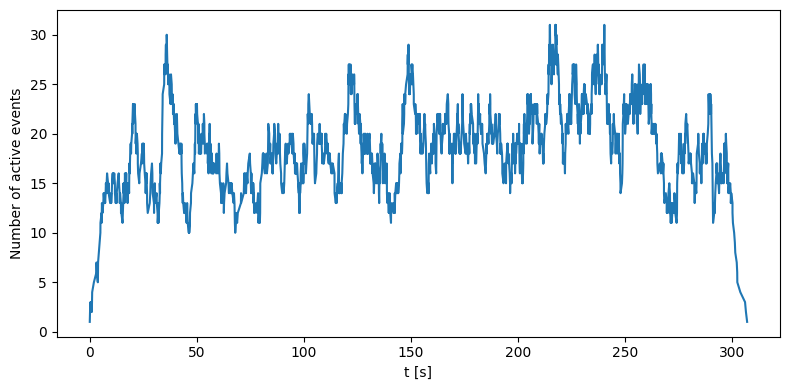

In [209]:
fig, ax = plt.subplots(1,1, figsize = (8, 4))

ax.plot(evolving_SBM.times[:-1], number_active_events)
ax.set_xlabel("t [s]")
ax.set_ylabel("Number of active events")

plt.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig('/home/b/skoove/Desktop/evolving_SBM/evolving_SBM_activity_function.png', format='png', dpi=300, bbox_inches='tight')

In [213]:
print(np.mean(number_active_events))
print(inter_tau / activ_tau)

19.153161592505853
20.0


In [210]:
matrix1_0 = evolving_SBM.compute_static_adjacency_matrix(start_time=0, end_time=100).toarray()
matrix2_0 = evolving_SBM.compute_static_adjacency_matrix(start_time=100, end_time=200).toarray()
matrix3_0 = evolving_SBM.compute_static_adjacency_matrix(start_time=200, end_time=300).toarray()

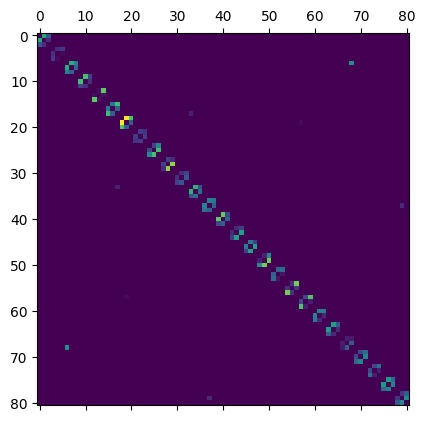

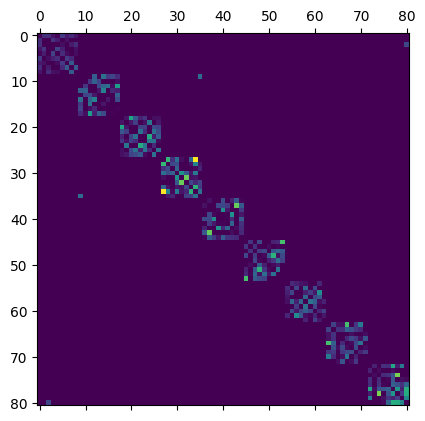

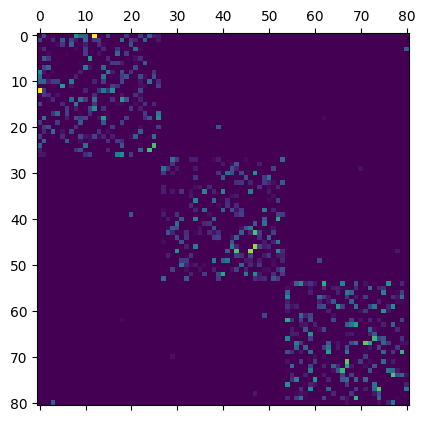

In [211]:
plt.matshow(matrix1_0)
plt.matshow(matrix2_0)
plt.matshow(matrix3_0)